In [15]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from swdf.losses import LossFactory
from swdf.metrics import ValidationMetricsHandler, LossMetrics

os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# Training the TSR Decomposed Geomagnetic Indices Dst and Ap Forecaster

In this notebook, we implement the training process for forecasting the Ap and Dst indices, which have been previously decomposed into their **trend**, **seasonal**, and **residual** additive components. Following the approach suggested by **Picialli et al. (2024)**, we use **LSTM algorithms** for trend and seasonal decomposition and **GRU** for residuals. However, we have also experimented with other combinations of architectures, keeping the configuration flexible. Details on the architecture configurations can be found in the `config/lstmplus.yaml` and `config/gruplus.yaml` files.

The reason for merging these two indices is that they are related, as both measure similar geomagnetic phenomena. This relationship allows the model to leverage information from one index to benefit the other. With that in mind, let's dive into the training process.


<details>
<summary><u>References</u></summary>
- F. Piccialli, et al. "GRAPHITE — Generative Reasoning and Analysis for Predictive Handling in Traffic Efficiency," in Information Fusion, vol. 106, pp. 102265, 2024.
</details>

In [16]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_geodstap = yaml2dict('./config/geodstap.yaml', attrdict=True).train
config_tsr = yaml2dict('./config/tsr_decomposition.yaml', attrdict=True)
config_train = config_tsr.train
config_data = config_tsr.data

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_geodstap,
                   **config_train,
                   "data":AttrDict({**config_data})})

# Add the architecture config

def config_arch(component:str):
    arch_name = config[f'{component}_arch_name'].lower()
    yaml_filename = f'./config/{arch_name}.yaml'

    try:
        config[f'arch_{component}'] = yaml2dict(yaml_filename, attrdict=True)
    except:
        config[f'arch_{component}'] = AttrDict()

config_arch('trend')
config_arch('seasonal')
config_arch('residual')

In [17]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [18]:
config

```json
{ 'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'arch_residual': { 'bidirectional': True,
                     'd_ff': 512,
                     'd_k': 64,
                     'd_v': 64,
                     'encoder_dropout': 0.1,
                     'encoder_layers': 3,
                     'fc_dropout': 0.3,
                     'hidden_size': 128,
                     'n_heads': 8,
                     'rnn_dropout': 0.3,
                     'rnn_layers': 2},
  'arch_seasonal': { 'bidirectional': True,
                     'd_ff': 512,
                     'd_k': 64,
                     'd_v': 64,
                     'encoder_dropout': 0.1,
                     'encoder_layers': 3,
                     'fc_dropout': 0.3,
                     'hidden_size': 128,
                     'n_heads': 8,
                     'rnn_dropout': 0.2,
                     'rnn_layers': 2},
  'arch_trend': { 'bidirectional': True,
                  'd_ff': 512,
                  'd_k': 64,
                  'd_v': 64,
                  'encoder_dropout': 0.1,
                  'encoder_layers': 3,
                  'fc_dropout': 0.3,
                  'hidden_size': 128,
                  'n_heads': 8,
                  'rnn_dropout': 0.2,
                  'rnn_layers': 2},
  'bs': 128,
  'data': { 'data_columns': [ 'DST_Trend',
                              'DST_Seasonal',
                              'DST_Residual',
                              'AP_Trend',
                              'AP_Seasonal',
                              'AP_Residual'],
            'data_nb': './geodstap_tsr_data.ipynb',
            'df_save_path': './preprocessed_data/dataframes/geodstap_tsr.pkl',
            'exp_pipe_save_path': './preprocessed_data/pipelines/exp_geodstap_tsr.pkl',
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap_tsr.pkl',
            'tsa_model': 'additive'},
  'horizon': 48,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 144,
  'loss_config': {},
  'loss_func': 'wMSE',
  'lr_max': None,
  'main_metric': 'default',
  'metrics_handler_path': None,
  'n_epoch': 10,
  'partial_n': 0.1,
  'residual_arch_name': 'GRUAttention',
  'residual_loss_config': {},
  'residual_loss_func': 'wRMSLE',
  'seasonal_arch_name': 'LSTMAttention',
  'seasonal_loss_config': {'quantile': 0.9},
  'seasonal_loss_func': 'Quantile',
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'trend_arch_name': 'LSTMAttention',
  'trend_loss_config': {},
  'trend_loss_func': 'wMAE',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [19]:
df, preproc_pipe, exp_pipe = generate_preprocessed_data(config.data)

df

,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377400,-5.197962,-5.179439
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097114,13.377386,4.516296,4.106318
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140036,13.377373,6.230586,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949211,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180696,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949176,-4.500100,2.550924


Since the thresholds will remain the same as those used when training the non-decomposed indices, we will simply copy the threshold values for each geomagnetic index across all possible combinations.


In [34]:
thresholds_dstap = yaml2dict('preprocessed_data/categorization/thresholds_geodstap.yaml')
activity_levels_dstap = yaml2dict('preprocessed_data/categorization/activity_levels_geodstap.yaml')

components = ['Trend', 'Seasonal', 'Residual']
thresholds, activity_levels = {}, {}

for index in thresholds_dstap.keys():
    for component in components:
        thresholds[f"{index}_{component}"] = thresholds_dstap[index]
        activity_levels[f"{index}_{component}"] = activity_levels_dstap[index]
thresholds, activity_levels

({'AP_Trend': [(-inf, 10), (10, 50), (50, inf)],
  'AP_Seasonal': [(-inf, 10), (10, 50), (50, inf)],
  'AP_Residual': [(-inf, 10), (10, 50), (50, inf)],
  'DST_Trend': [(-30, inf),
   (-50, -30),
   (-90, -50),
   (-130, -90),
   (-350, -130),
   (-inf, -350)],
  'DST_Seasonal': [(-30, inf),
   (-50, -30),
   (-90, -50),
   (-130, -90),
   (-350, -130),
   (-inf, -350)],
  'DST_Residual': [(-30, inf),
   (-50, -30),
   (-90, -50),
   (-130, -90),
   (-350, -130),
   (-inf, -350)]},
 {'AP_Trend': ['Low', 'Moderate', 'Active'],
  'AP_Seasonal': ['Low', 'Moderate', 'Active'],
  'AP_Residual': ['Low', 'Moderate', 'Active'],
  'DST_Trend': ['G0', 'G1', 'G2', 'G3', 'G4', 'G5'],
  'DST_Seasonal': ['G0', 'G1', 'G2', 'G3', 'G4', 'G5'],
  'DST_Residual': ['G0', 'G1', 'G2', 'G3', 'G4', 'G5']})

## Data Splitting

In this case, we have significantly more data than when forecasting the FSMY 10.7 solar indices, as we have older data from both indices (dating back to 1957) and a much higher resolution (8 measurements per day). Therefore, we did not need to use more complex data splitting strategies. We simply selected a test period, with the period before it as the training set, and the period after it (the most recent values) as the validation set. We will do so for the 3 components of the TSR decomposition.

We have again used the test period from [Licata et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496), as we want to compare our results with theirs. They used data from **October 2012 through the end of 2018** for benchmarking.


In [21]:
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

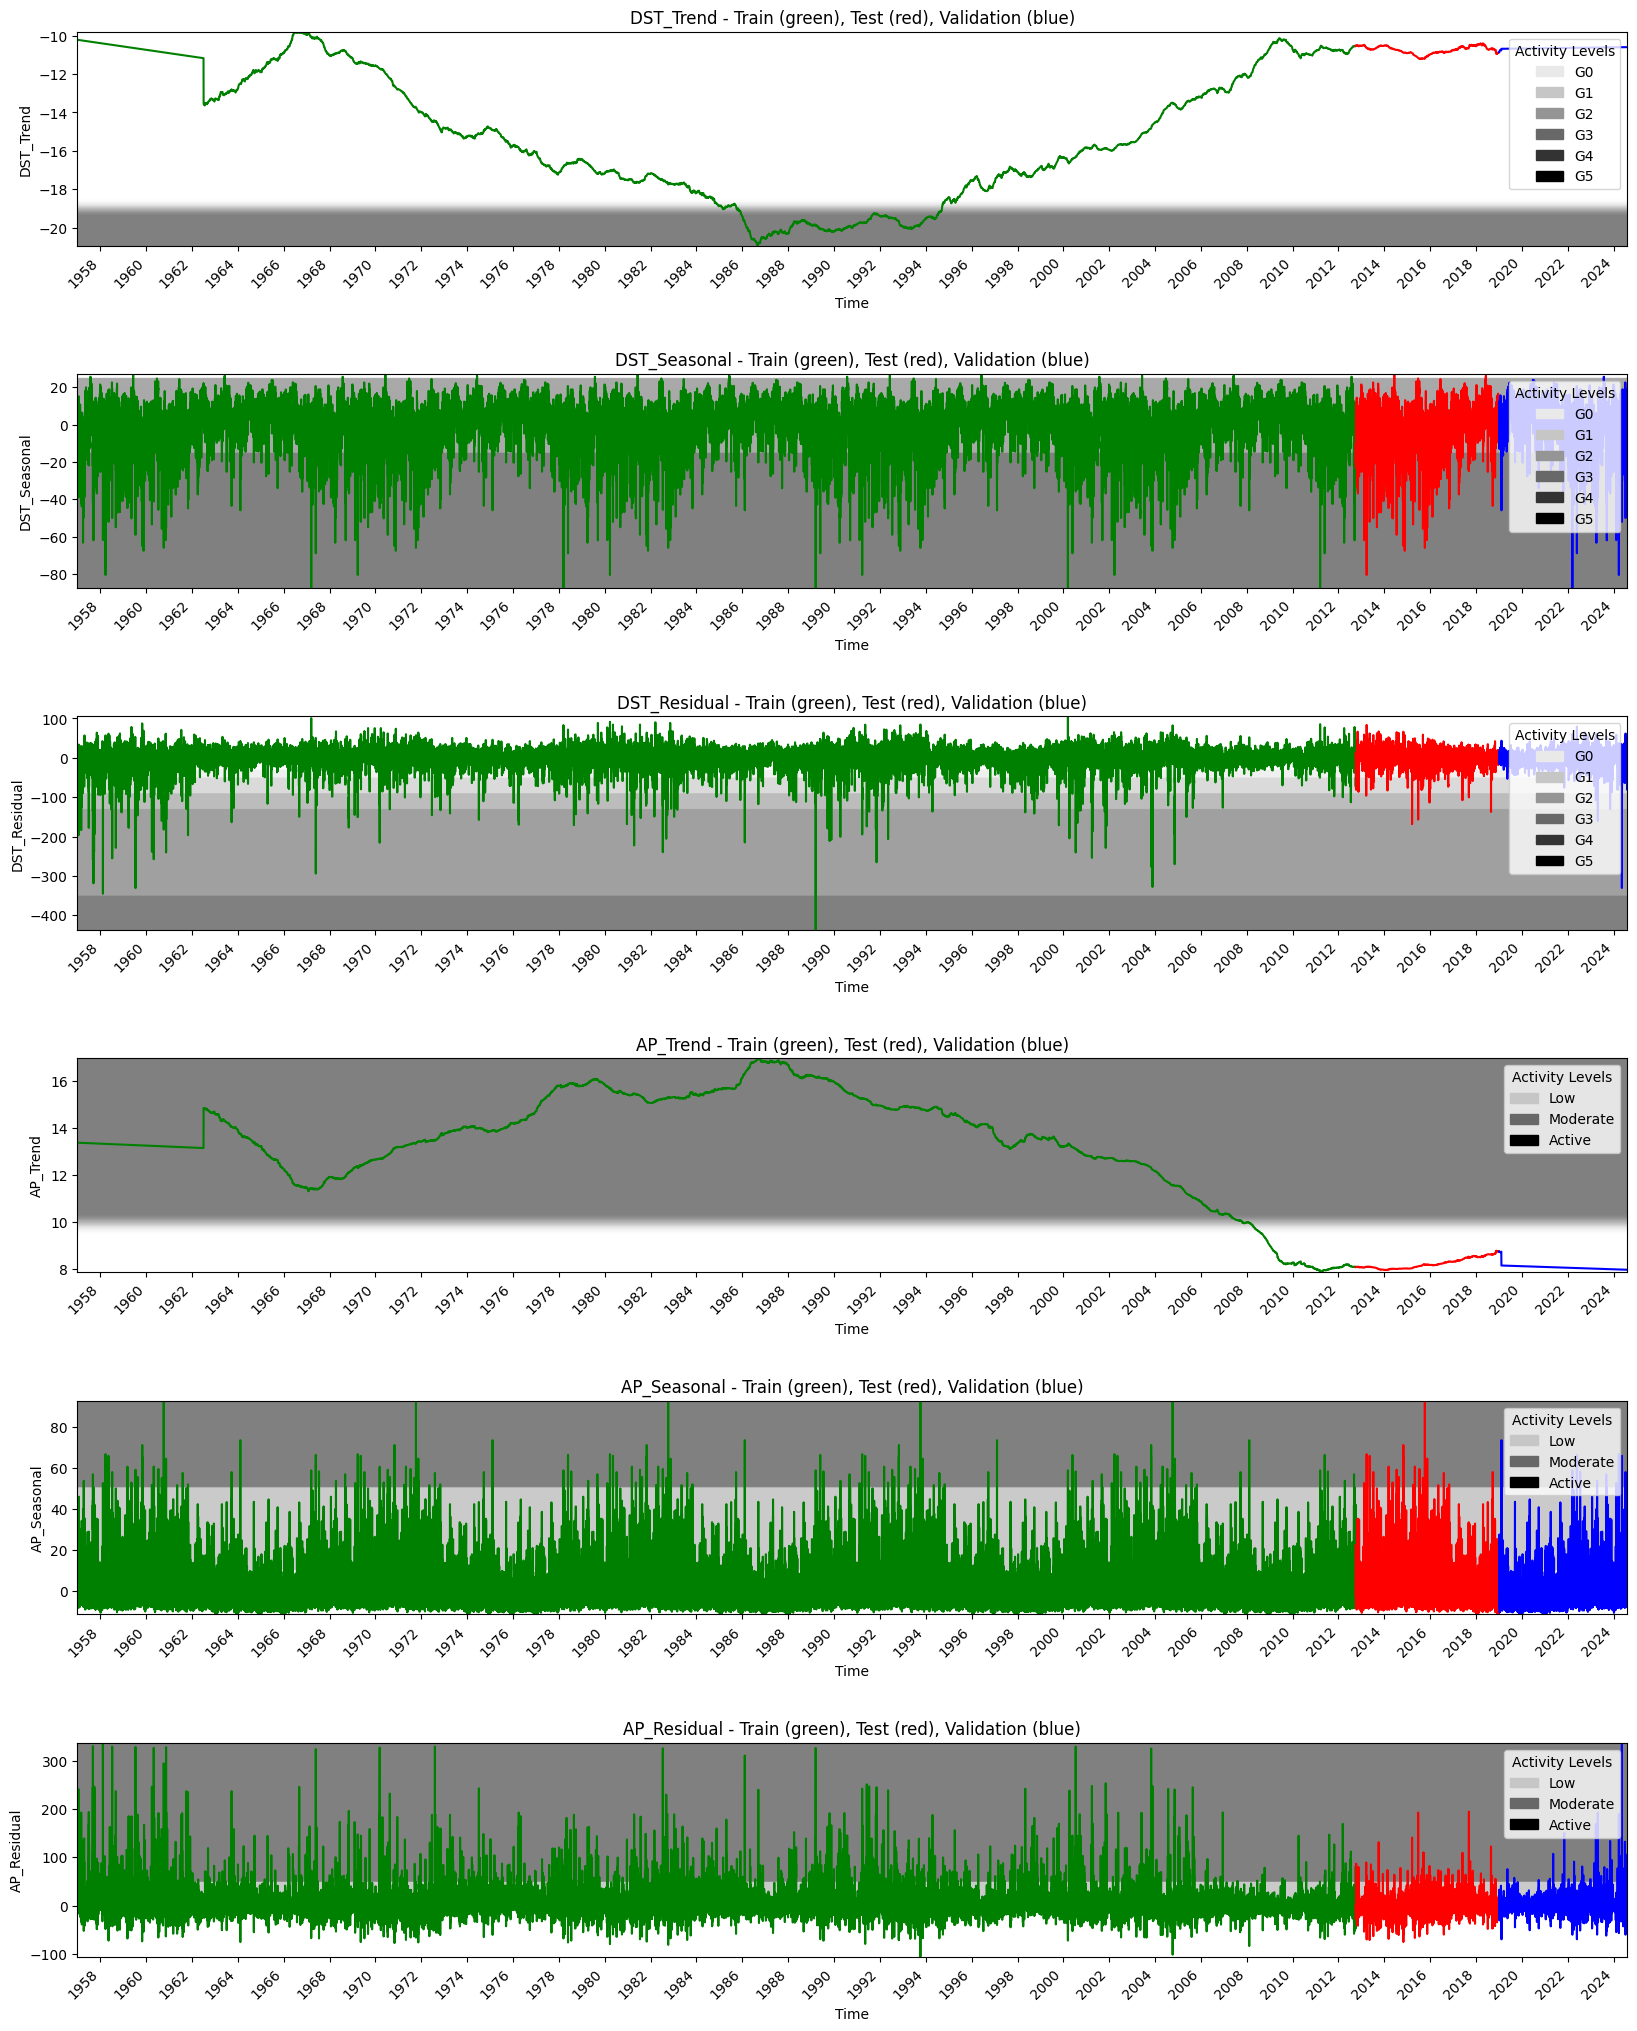

In [22]:
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# Create the subplots
fig, ax = plt.subplots(6, 1, figsize=(20, 25))
plt.subplots_adjust(hspace=0.6)

# Loop over the data columns to plot the main time series with shaded regions for train, test, validation
for i, value in enumerate(config.data.data_columns):
    # Scatter plot for train, test, validation with different colors
    ax[i].plot(df.Datetime[(df.Datetime < test_start_datetime)], 
                  df[value][(df.Datetime < test_start_datetime)], label='Train', color='green')
    
    ax[i].plot(df.Datetime[(df.Datetime >= test_start_datetime) & (df.Datetime <= test_end_datetime)], 
                  df[value][(df.Datetime >= test_start_datetime) & (df.Datetime <= test_end_datetime)], label='Test', color='red')
    
    ax[i].plot(df.Datetime[(df.Datetime > test_end_datetime)], 
                  df[value][(df.Datetime > test_end_datetime)], label='Validation', color='blue')
    
    # Apply the thresholds for the specific variable
    min_val, max_val = df[value].min(), df[value].max()
    set_ranges = np.zeros((df.shape[0], int(max_val - min_val)))

    for j, (start, end) in enumerate(thresholds[value]):
        start = -99999 if np.abs(start) == np.inf else start
        end = 99999 if np.abs(end) == np.inf else end

        mask = (df[value] >= start) & (df[value] < end)
        set_ranges[:, int(start - min_val):int(end - min_val)] = ((j + 1) / len(thresholds[value]))
    
    # Apply the 'Greys' colormap
    ax[i].imshow(set_ranges.T, extent=[df.Datetime.min(), df.Datetime.max(), min_val, max_val],
                 aspect='auto', alpha=0.5, origin='lower', cmap='Greys')

    # Title and labels
    ax[i].set_title(f'{value} - Train (green), Test (red), Validation (blue)')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel(value)

    # Format x-axis to show only the years
    ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right")

    # Create legend for activity levels
    legend_labels = activity_levels[value]
    colors = [plt.cm.Greys((j + 1) / len(legend_labels)) for j in range(len(legend_labels))]
    patches = [mpatches.Patch(color=colors[j], label=legend_labels[j]) for j in range(len(legend_labels))]
    ax[i].legend(handles=patches, loc='upper right', title='Activity Levels')

# Show the plot
plt.show()


In [23]:
# Test and Training sets generation
splits_ = get_forecasting_splits(
    df[df.Datetime < valid_start_datetime], 
    fcst_history=config.lookback, 
    fcst_horizon=config.horizon, 
    use_index=False, 
    test_cutoff_datetime=test_start_datetime, 
    show_plot=False, 
    datetime_col='Datetime'
)

# Validation set generation
validation_data = df[df.Datetime >= valid_start_datetime]

validation_splits = get_forecasting_splits(
    validation_data, 
    fcst_history=config.lookback, 
    fcst_horizon=config.horizon, 
    valid_size=0.0, 
    test_size=0.0, 
    show_plot=False
)

val_idxs = L(validation_data.index[validation_splits[0]].tolist())

# Combination of the different set
splits = (splits_[0], val_idxs, splits_[1])
splits


((#162710) [0,1,2,3,4,5,6,7,8,9...],
 (#19088) [178244,178245,178246,178247,178248,178249,178250,178251,178252,178253...],
 (#15296) [162757,162758,162759,162760,162761,162762,162763,162764,162765,162766...])

In [24]:
def prepare_data(condition:str):
    data_columns = [data_column + f"_{condition}" for data_column in ['AP', 'DST']]

    X, y = prepare_forecasting_data(df, fcst_history=config.lookback, 
                                    fcst_horizon=config.horizon,
                                    x_vars=data_columns, 
                                    y_vars=data_columns)
    return X, y 

X_trend, y_trend = prepare_data('Trend')
X_seasonal, y_seasonal = prepare_data('Seasonal')
X_residual, y_residual = prepare_data('Residual')

X_trend.shape, y_trend.shape

((197332, 2, 144), (197332, 2, 48))

## Training the Forecaster

This section implements the entire training process for the forecasting model, which in this case will be composed of three different learners, each with a distinct architecture for the indices used.

### Generate Weights

Although we are not dealing with an imbalanced training set like in the FSMY 10.7 forecaster (see the `solfsmy_train` notebook), the values are still not equally distributed across all solar activity levels. To address this, we assign weights to the training process using the inverse frequency of each level. This ensures that errors in forecasting the less-represented values are more heavily penalized. These weights are calculated for each component of the TSR analysis.


In [25]:
df_cat = get_classified_columns(df, thresholds, activity_levels)

def get_weights(column:pd.Series):
    distribution = column.value_counts(normalize=True).to_dict()
    inverted_weights = {category: 1 / frequency for category, frequency in distribution.items()}
    total_weight = sum(inverted_weights.values())
    normalized_weights = [weight / total_weight for weight in inverted_weights.values()]
    return normalized_weights

weights = {
    column: get_weights(df_cat[df.Datetime < test_start_datetime][f'{column}_Cat'])
    for column in config.data.data_columns
}

weights

{'DST_Trend': [1.0],
 'DST_Seasonal': [0.0012246512259417675,
  0.10006029340417144,
  0.8987150553698867],
 'DST_Residual': [6.5015921784102315e-06,
  0.00015855405479093382,
  0.0003582316396429168,
  0.0016546606183839216,
  0.003371020446266905,
  0.9944510316487369],
 'AP_Trend': [0.0888766114180479, 0.9111233885819522],
 'AP_Seasonal': [0.0016780502470202113,
  0.017554432345950634,
  0.9807675174070293],
 'AP_Residual': [0.017388378427321136,
  0.12122851840410333,
  0.8613831031685757]}

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wandb_callback = WandbCallback(log_preds=False)
callbacks = L(wandb_callback) if config.wandb.enabled else L()
callbacks += ShowGraphCallback()

def execute_learner(X, y, component):

    thresholds_filtered = {key: value for key, value in thresholds.items() if component in key.lower()}
    weights_filtered = {key: value for key, value in weights.items() if component in key.lower()}

    # Initialize the loss function with the provided thresholds and weights
    loss = LossFactory(thresholds=thresholds_filtered, weights=weights_filtered).create(
        config[f'{component}_loss_func'], **config[f"{component}_loss_config"]
    ).to(device)

    # Set up metrics 
    if config.metrics_handler_path is not None:
        metrics_handler = load_object(config.metrics_handler_path)
    else:
        metrics_handler = LossMetrics(loss, 'GeoDSTAP')
    metrics = metrics_handler.get_metrics()

    learn = TSForecaster(
        X, y, splits=splits, 
        batch_size=config.bs,
        pipelines=[preproc_pipe, exp_pipe], 
        metrics=metrics,
        loss_func=loss,
        arch=config[f'{component}_arch_name'], arch_config=config[f'arch_{component}'],
        init=config.init_weights,
        cbs= callbacks, 
        partial_n=config.partial_n)
    learn.to(device)

    try: # In some extreme cases it can fail and return an error
        lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
    except:
        lr_max = 1e-3

    learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)

    return learn, metrics_handler

epoch,train_loss,valid_loss,Loss_Low,Loss_Medium,Loss_Active,Loss_G0,Loss_G1,Loss_G2,Loss_G3,Loss_G4,Loss_G5,time
0,4.532663,0.377220,0.053240,0.000000,0.000000,0.323980,0.000000,0.000000,0.000000,0.000000,0.000000,00:22
1,0.806049,0.427856,0.026319,0.000000,0.000000,0.401537,0.000000,0.000000,0.000000,0.000000,0.000000,00:22
2,0.466984,0.153388,0.015531,0.000000,0.000000,0.137857,0.000000,0.000000,0.000000,0.000000,0.000000,00:22
3,0.392299,0.304326,0.010976,0.000000,0.000000,0.293350,0.000000,0.000000,0.000000,0.000000,0.000000,00:22
4,0.356350,0.253520,0.014540,0.000000,0.000000,0.238980,0.000000,0.000000,0.000000,0.000000,0.000000,00:22
5,0.333280,0.318675,0.015219,0.000000,0.000000,0.303456,0.000000,0.000000,0.000000,0.000000,0.000000,00:23
6,0.261094,0.330250,0.012643,0.000000,0.000000,0.317606,0.000000,0.000000,0.000000,0.000000,0.000000,00:23
7,0.244183,0.115029,0.019367,0.000000,0.000000,0.095661,0.000000,0.000000,0.000000,0.000000,0.000000,00:23
8,0.205054,0.232015,0.014964,0.000000,0.000000,0.217051,0.000000,0.000000,0.000000,0.000000,0.000000,00:23
9,0.190060,0.207196,0.017764,0.000000,0.000000,0.189432,0.000000,0.000000,0.000000,0.000000,0.000000,00:23


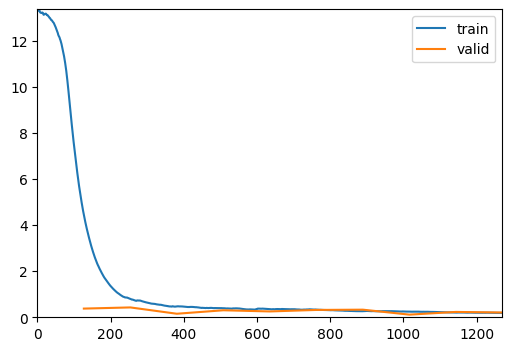

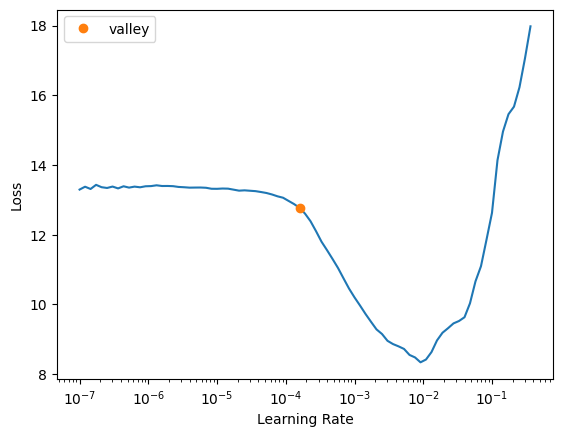

In [27]:
learn_trend, _ = execute_learner(X_trend, y_trend, component='trend')

epoch,train_loss,valid_loss,Metrics_Not_Available,time
0,2.746602,1.933263,nan,00:22
1,1.516500,1.286276,nan,00:22
2,1.381913,1.237079,nan,00:22
3,1.339333,1.207377,nan,00:22
4,1.282795,1.159668,nan,00:22
5,1.228050,1.132684,nan,00:22
6,1.190297,1.089801,nan,00:22
7,1.146257,1.068461,nan,00:22
8,1.141184,1.059029,nan,00:22
9,1.143615,1.058354,nan,00:22


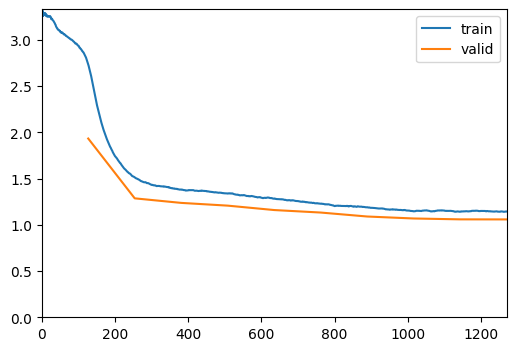

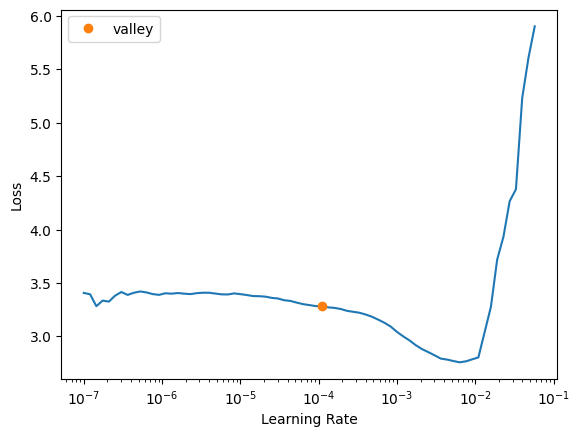

In [28]:
learn_seasonal, _ = execute_learner(X_seasonal, y_seasonal, component='seasonal')

epoch,train_loss,valid_loss,Metrics_Not_Available,time
0,0.524119,0.335935,nan,00:21
1,0.513141,0.335723,nan,00:21
2,0.517689,0.335206,nan,00:21
3,0.507698,0.333087,nan,00:21
4,0.506562,0.335284,nan,00:21
5,0.507772,0.330862,nan,00:21
6,0.499812,0.328360,nan,00:21
7,0.489522,0.327068,nan,00:21
8,0.490889,0.326384,nan,00:21
9,0.491289,0.326155,nan,00:21


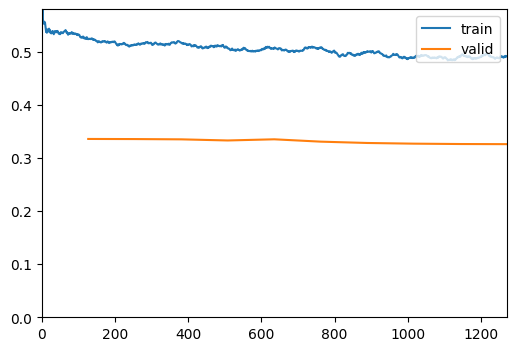

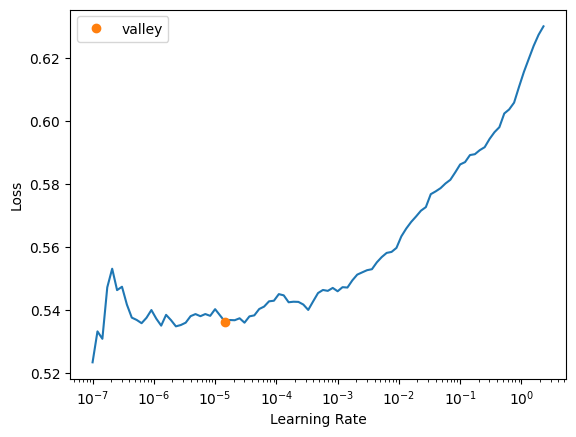

In [29]:
learn_residual, metrics_handler = execute_learner(X_residual, y_residual, component='residual')

## Model Saving

In [31]:
if config.metrics_handler_path is not None:
    valid_metrics = {}

    for metric1, metric2, metric3 in zip(learn_trend.recorder.metrics, learn_residual.recorder.metrics, learn_seasonal.recorder.metrics):
        valid_metrics[metric1.name] = [(metric1.value + metric2.value + metric3.value)/3]
else:
    valid_metrics = [AttrDict({
        "name": f"TSR_Validation_Losses",
        "value": (learn_trend.validate()[0] + learn_seasonal.validate()[0] + learn_residual.validate()[0]) / 3
    })]

%store valid_metrics

print({metric.name: metric.value for metric in valid_metrics})

Stored 'valid_metrics' (list)
{'TSR_Validation_Losses': 0.5305684556563696}


In [32]:
# Save everything
learn_trend.dls.loaders += [learn_trend.dls.valid.new_dl(X_trend[splits[2]], y_trend[splits[2]])] 
learn_seasonal.dls.loaders += [learn_seasonal.dls.valid.new_dl(X_seasonal[splits[2]], y_seasonal[splits[2]])] 
learn_residual.dls.loaders += [learn_residual.dls.valid.new_dl(X_residual[splits[2]], y_residual[splits[2]])] 

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn_trend.remove_cb(wandb_callback)
    learn_seasonal.remove_cb(wandb_callback)
    learn_residual.remove_cb(wandb_callback)

In [39]:
best_valid_metrics = None
%store -r best_valid_metrics

save_all_or_best = (
    config.is_optuna_study and 
    metrics_handler.are_best_values(best_valid_metrics, valid_metrics)
) or not config.is_optuna_study

if save_all_or_best:
    best_valid_metrics = valid_metrics
    %store best_valid_metrics

    # Save all relevant components locally
    learn_trend.save_all(path='tmp', verbose=True, model_fname='model_dstap_trend', learner_fname="learner_dstap_trend") 
    learn_seasonal.save_all(path='tmp', verbose=True, model_fname='model_dstap_seasonal', learner_fname="learner_dstap_seasonal") 
    learn_residual.save_all(path='tmp', verbose=True, model_fname='model_dstap_residual', learner_fname="learner_dstap_residual") 

    # Save the learner to Wandb if online and enabled
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        run.log_artifact('tmp', type='learner', name='geodestap_tsr')
    
    # Save the best model with relevant configuration
    model = {
        'models': {
                    'Trend':learn_trend.model, 
                    'Seasonal': learn_seasonal.model, 
                    'Residual': learn_residual.model
                    },
        'lookback': config.lookback,
        'horizon': config.horizon,
        'data_columns': ['DST', 'AP'],
        'thresholds': thresholds,
        'components': components
    }
    
    torch.save(model, 'models/best/best_model_tsr_geodstap.pth')

Stored 'best_valid_metrics' (list)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_trend.pth'
learner_fname = 'learner_dstap_trend.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_seasonal.pth'
learner_fname = 'learner_dstap_seasonal.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap_residual.pth'
learner_fname = 'learner_dstap_residual.pkl'
